<a href="https://colab.research.google.com/github/srijonpal/Concrete-Strength-Prediction/blob/main/concrete_strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1>Concrete Strength Prediction</h1><b>

In [ ]:
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import model_selection

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/concrete_data.csv")

In [ ]:
df.shape


(1030, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [ ]:
# Define all covariates and outcomes from `df`.
regression_target = 'Strength'
all_covariates = df.columns[df.columns != 'Strength'];

regression_outcome = df[regression_target]
covariates = df[all_covariates]


In [ ]:
covariates_norm = (covariates - covariates.mean()) / covariates.std()
regression_norm = (regression_outcome - regression_outcome.mean()) / regression_outcome.std()

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize = (12,12));
# i = 0;
# for r in range(3):
#     for c in range(3):
#       try:
#         sns.boxplot(new[all_covariates[i]], ax=axes[r][c]);
#         i += 1
#       except:
#         pass


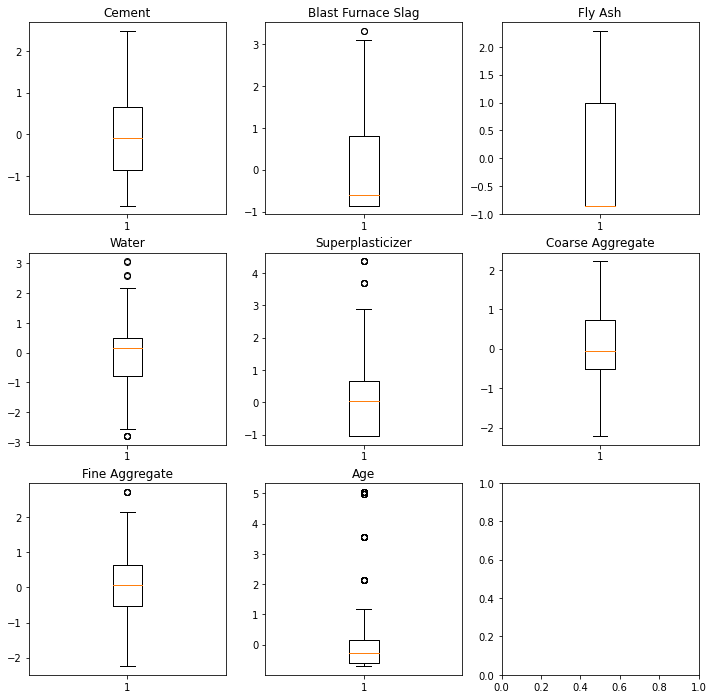

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (12,12))
i = 0;
for r in range(3):
    for c in range(3):
      try:
        axs[r, c].boxplot(covariates_norm[all_covariates[i]])
        axs[r, c].set_title(all_covariates[i])
        i += 1
      except:
        pass

In [ ]:
def cap_outliers(df, col):
    q1 = df.describe()[col].loc["25%"]
    q3 = df.describe()[col].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df.loc[df[col] < lower_bound, col] = df.describe()[col].loc["mean"]
    df.loc[df[col] > upper_bound, col] = df.describe()[col].loc["mean"]
    return df

In [ ]:
for col in all_covariates:
    df = cap_outliers(covariates_norm, col)

updated_covariate_norm = df

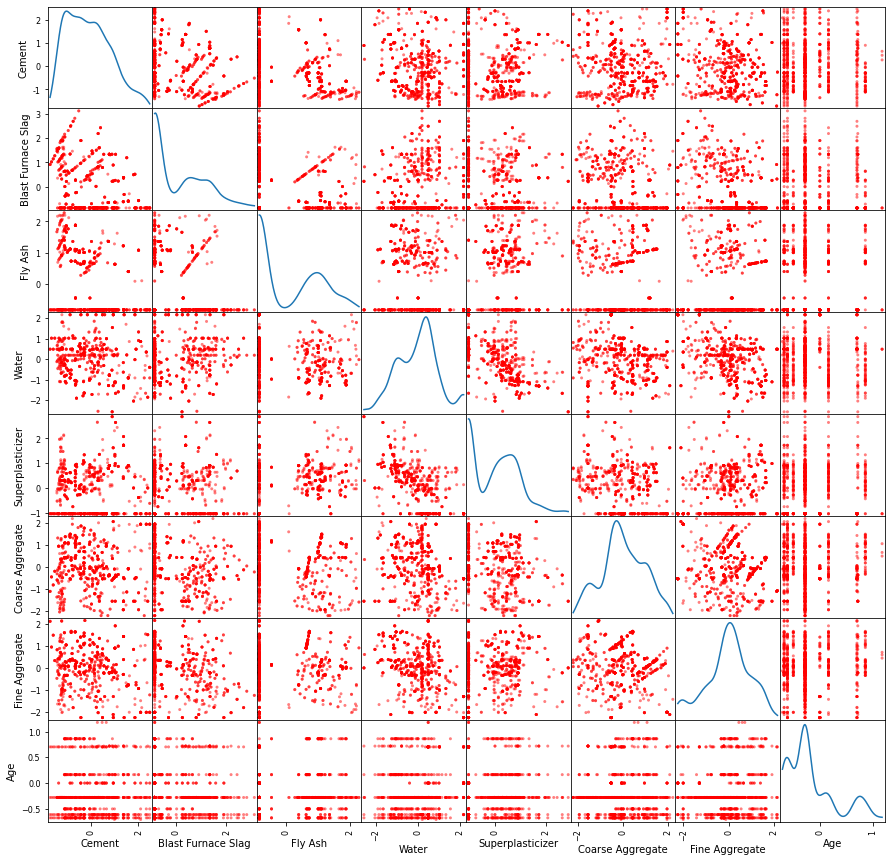

Cement                0.509481
Blast Furnace Slag    0.773670
Fly Ash               0.537354
Water                 0.093804
Superplasticizer      0.469213
Coarse Aggregate     -0.040220
Fine Aggregate       -0.331815
Age                   1.164272
dtype: float64

In [ ]:
axes = pd.plotting.scatter_matrix( updated_covariate_norm[all_covariates], alpha=0.5,figsize=(15, 15),
                            marker = '.', color=(1,0,0), grid = True, diagonal="kde")
# show the plot.
plt.show();
# determine the skew.
updated_covariate_norm.skew(axis = 0)[all_covariates]

In [ ]:
# Instantiate all regression models.
linear_regression = LinearRegression(fit_intercept = True)
forest_regression = RandomForestRegressor(max_depth = 6,random_state = 0)

In [ ]:
seed = 1;
train_X, test_X, train_y, test_y = train_test_split(updated_covariate_norm, regression_norm, test_size = 0.2, random_state = seed)


In [ ]:
train_X.shape[1]

8

In [ ]:
linear_regression_result = linear_regression.fit(train_X,train_y)

In [ ]:
linear_regression_result.score(test_X,test_y)

0.679815434594963

In [ ]:
col_names = df.columns.to_list()

In [ ]:
evaluation = {"Metrics" : ['Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R2 score', 'CV-mean']}
def evaluate_model(name, train_X, train_y, test_X, test_y, types, alg, plot=True):
    global evaluation, pred
    
    alg.fit(train_X, train_y)
    print(f"Score: {alg.score(test_X, test_y)}")
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(20, 10))
        try:
            if types == "Coefs":
                print(f"Intercept: {alg.intercept_}")
                try:
                    coefs = pd.DataFrame({"coefs" : alg.coef_, "col" : col_names})
                except:
                    coefs = pd.DataFrame({"coefs" : alg.coef_[0], "col" : col_names})
                sns.barplot(x="col", y="coefs", data=coefs, ax=axes[1]);
            else:
                features = pd.DataFrame({"features" : alg.feature_importances_, "col" : col_names})
                sns.barplot(x="col", y="features", data=features, ax=axes[1]);
        except:
            pass
    else:
        plt.figure(figsize=(20,5));
        axes = [None]

    pred = alg.predict(test_X)
    rmsecm = np.sqrt(metrics.mean_squared_error(test_y,pred))
    mae = mean_absolute_error(test_y, pred)
    mse = mean_squared_error(test_y, pred)
    r2 = r2_score(test_y, pred)

    p = pd.DataFrame(pred, columns=[0])
    p["Type"] = "Predictions"
    p["n"] = list(range(p.shape[0]))
    t = test_y.copy()
    t = t.reset_index().set_index("index")
    t.columns = [0]
    t["Type"] = "Actual"
    t = t[t[0] != "Actual"]
    t["n"] = list(range(p.shape[0]))
    x = pd.concat([p,t], axis=0).reset_index()
    sns.lineplot(x="n", y=0, hue="Type", data=x, markers=["o", "o"], style="Type", ax=axes[0]);
    
    cv = cross_val_score(alg, test_X, test_y, cv=10)
    cv_mean = cv.ravel().mean()
    
    evaluation[name] = [rmsecm, mae, mse, r2, cv_mean]
    df_ev = pd.DataFrame(evaluation)
    plt.show()
    return df_ev, cv

Score: 0.679815434594963
Intercept: 0.24270759375756215


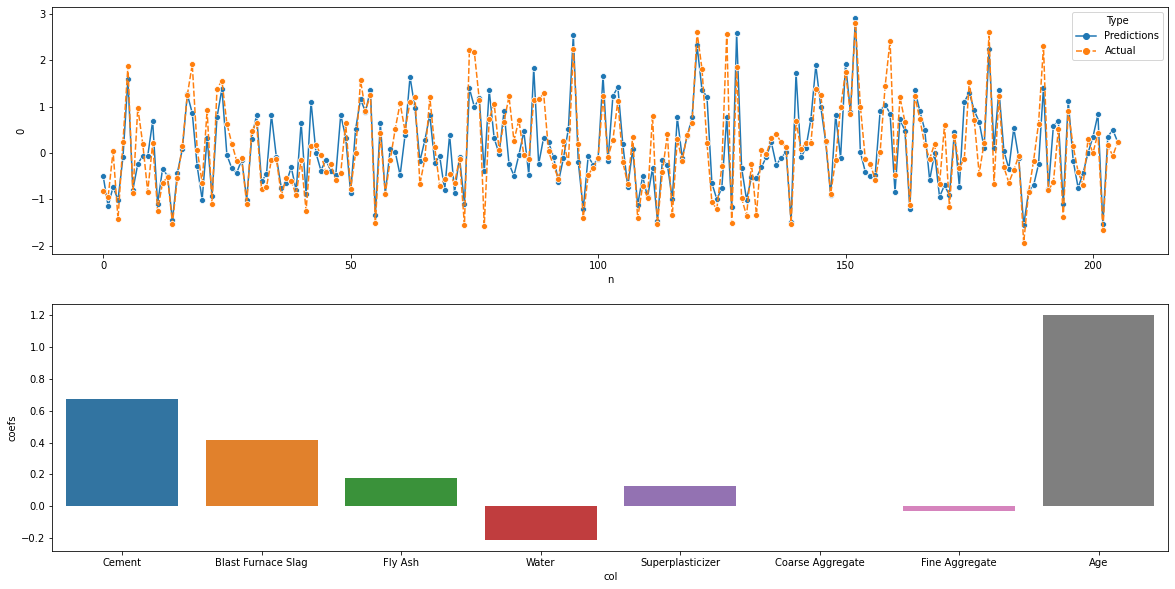

,Multiple Regression
Metrics,
Root Mean Squared Error (RMSE),0.546891
Mean Absolute Error (MAE),0.409823
Mean Squared Error (MSE),0.299089
R2 score,0.679815
CV-mean,0.646425


In [ ]:
lr = linear_model.LinearRegression()
evaluation, cv_scores = evaluate_model("Multiple Regression", train_X, train_y, test_X, test_y, "Coefs", lr)
evaluation.set_index("Metrics")

Score: 0.6800411104219104
Intercept: 0.24121305760549036


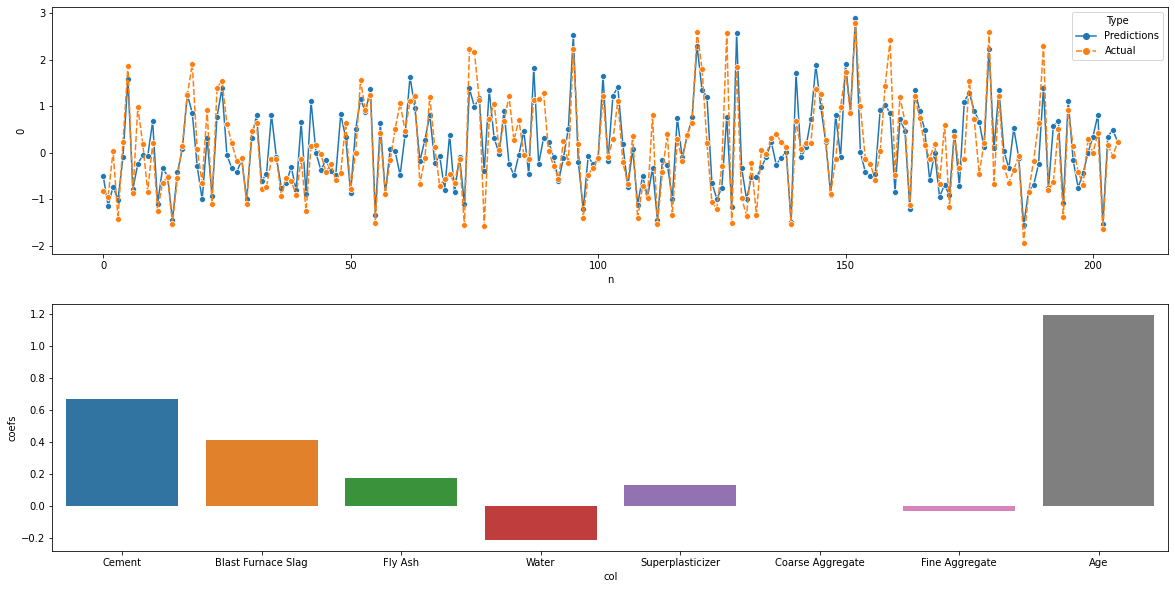

,Multiple Regression,Ridge
Metrics,,
Root Mean Squared Error (RMSE),0.546891,0.546698
Mean Absolute Error (MAE),0.409823,0.409903
Mean Squared Error (MSE),0.299089,0.298878
R2 score,0.679815,0.680041
CV-mean,0.646425,0.647082


In [ ]:
rg = linear_model.Ridge()
evaluation, cv_scores = evaluate_model("Ridge", train_X, train_y, test_X, test_y, "Coefs", rg)
evaluation.set_index("Metrics")

Score: 0.8248811920668255


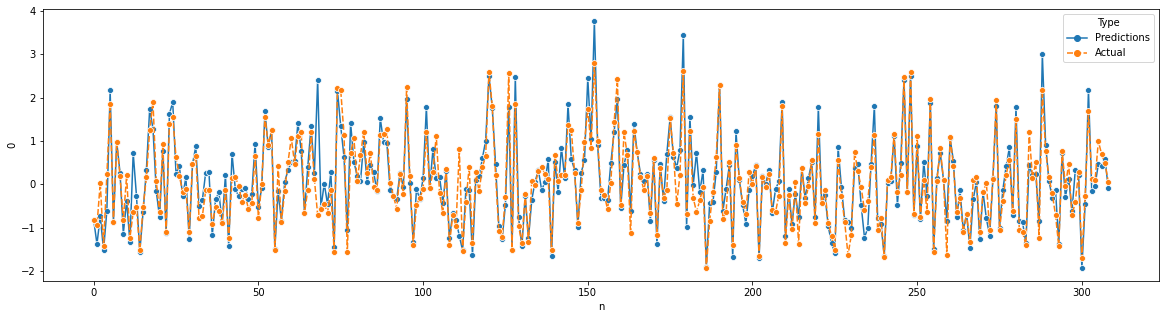

,Multiple Regression,Ridge,Polynomial Regression
Metrics,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546
Mean Absolute Error (MAE),0.409823,0.409903,0.270600
Mean Squared Error (MSE),0.299089,0.298878,0.164468
R2 score,0.679815,0.680041,0.824881
CV-mean,0.646425,0.647082,-7.329315


In [ ]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(updated_covariate_norm)

train_X_poly, test_X_poly, train_y_poly, test_y_poly = train_test_split(X_poly, regression_norm, test_size = 0.3, random_state = seed)

plr = LinearRegression()
evaluation, cv_scores = evaluate_model("Polynomial Regression", train_X_poly, train_y_poly, test_X_poly, test_y_poly,  "Coefs", plr, plot=False)
evaluation.set_index("Metrics")

Score: 0.6682947057640956
Intercept: [0.21592958]


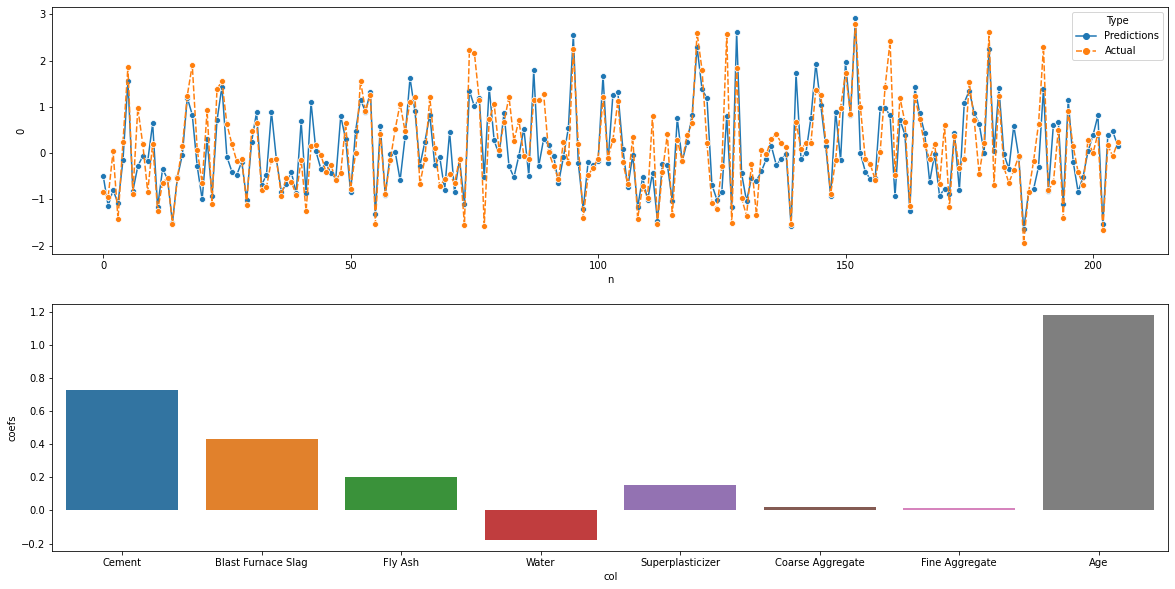

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression
Metrics,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851
R2 score,0.679815,0.680041,0.824881,0.668295
CV-mean,0.646425,0.647082,-7.329315,0.634801


In [ ]:
svr = SVR(C=10, kernel="linear")
evaluation, cv_scores = evaluate_model("Support Vector Regression", train_X, train_y, test_X, test_y, "Coefs", svr)
evaluation.set_index("Metrics")

Score: 0.6617126366613094


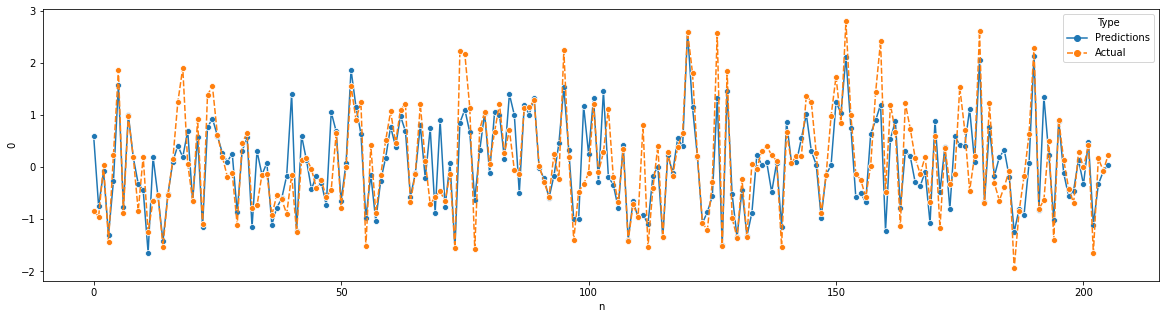

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression,KNN
Metrics,,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643,0.562138
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192,0.392322
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851,0.315999
R2 score,0.679815,0.680041,0.824881,0.668295,0.661713
CV-mean,0.646425,0.647082,-7.329315,0.634801,0.501885


In [ ]:
knn = KNeighborsRegressor(n_neighbors=4, metric="manhattan", weights="distance")
evaluation, cv_scores = evaluate_model("KNN", train_X, train_y, test_X, test_y, "Coefs", knn, plot=False)
evaluation.set_index("Metrics")

Score: 0.825970823228916


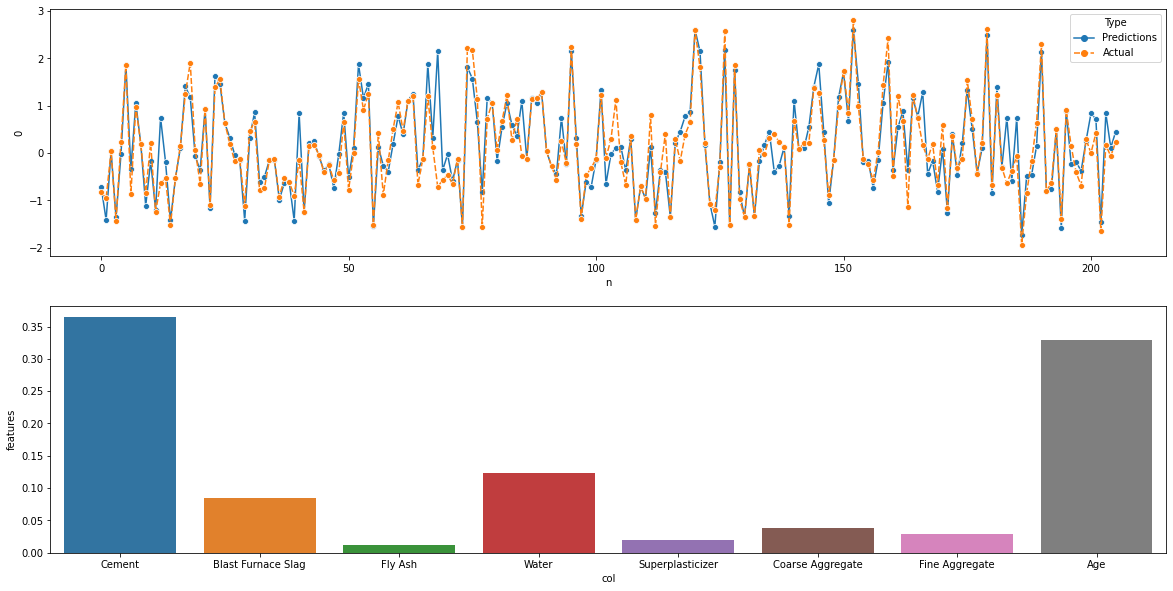

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression,KNN,Decision Tree Regression
Metrics,,,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643,0.562138,0.403191
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192,0.392322,0.250132
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851,0.315999,0.162563
R2 score,0.679815,0.680041,0.824881,0.668295,0.661713,0.825971
CV-mean,0.646425,0.647082,-7.329315,0.634801,0.501885,0.520971


In [ ]:
dtr = DecisionTreeRegressor()
evaluation, cv_scores = evaluate_model("Decision Tree Regression", train_X, train_y, test_X, test_y, "Features", dtr)
evaluation.set_index("Metrics")

Score: 0.8901845175493075


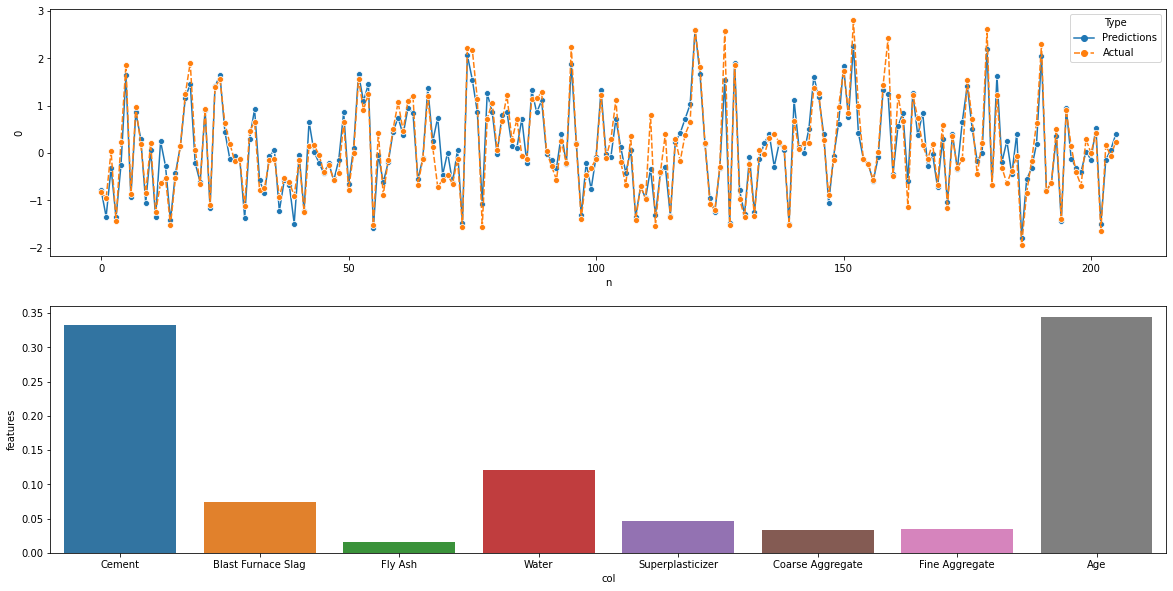

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression,KNN,Decision Tree Regression,Random Forest Regression
Metrics,,,,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643,0.562138,0.403402,0.320282
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192,0.392322,0.250370,0.221552
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851,0.315999,0.162733,0.102580
R2 score,0.679815,0.680041,0.824881,0.668295,0.661713,0.825789,0.890185
CV-mean,0.646425,0.647082,-7.329658,0.634801,0.501885,0.514253,0.779055


In [ ]:
rfr = RandomForestRegressor()
evaluation, cv_scores = evaluate_model("Random Forest Regression", train_X, train_y, test_X, test_y, "Features", rfr)
evaluation.set_index("Metrics")

[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score: 0.8879018325607927
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

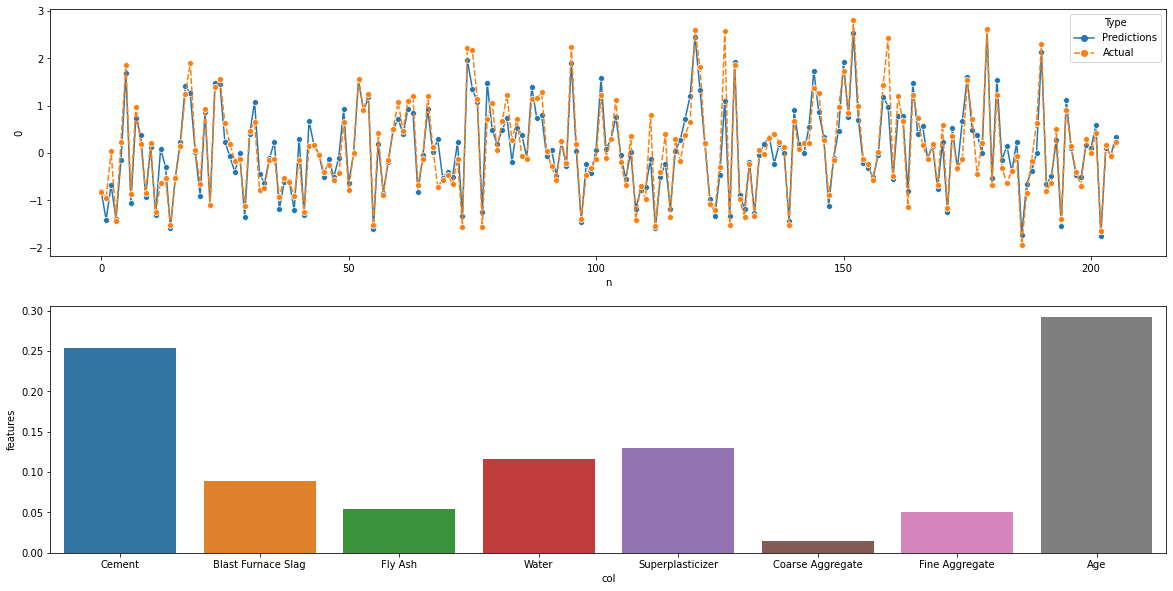

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression,KNN,Decision Tree Regression,Random Forest Regression,XGBoost
Metrics,,,,,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643,0.562138,0.403402,0.320282,0.323593
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192,0.392322,0.250370,0.221552,0.228114
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851,0.315999,0.162733,0.102580,0.104713
R2 score,0.679815,0.680041,0.824881,0.668295,0.661713,0.825789,0.890185,0.887902
CV-mean,0.646425,0.647082,-7.329658,0.634801,0.501885,0.514253,0.779055,0.814768


In [ ]:
xgc = XGBRegressor()
evaluation, cv_scores = evaluate_model("XGBoost", train_X, train_y, test_X, test_y, "Features", xgc)
evaluation.set_index("Metrics")

In [ ]:
model = XGBRegressor(n_jobs=4)

parameters = {
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'gamma': [0.001, 0.01],
    'learning_rate': [0.01, 0.1],
    'booster': ['gbtree']
}

grid_obj = GridSearchCV(
    estimator=xgc,
    param_grid=parameters
)

grid_obj.fit(updated_covariate_norm, regression_norm)

best_model = grid_obj.best_estimator_
print(best_model)

[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[10:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score: 0.906790030903958
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now 

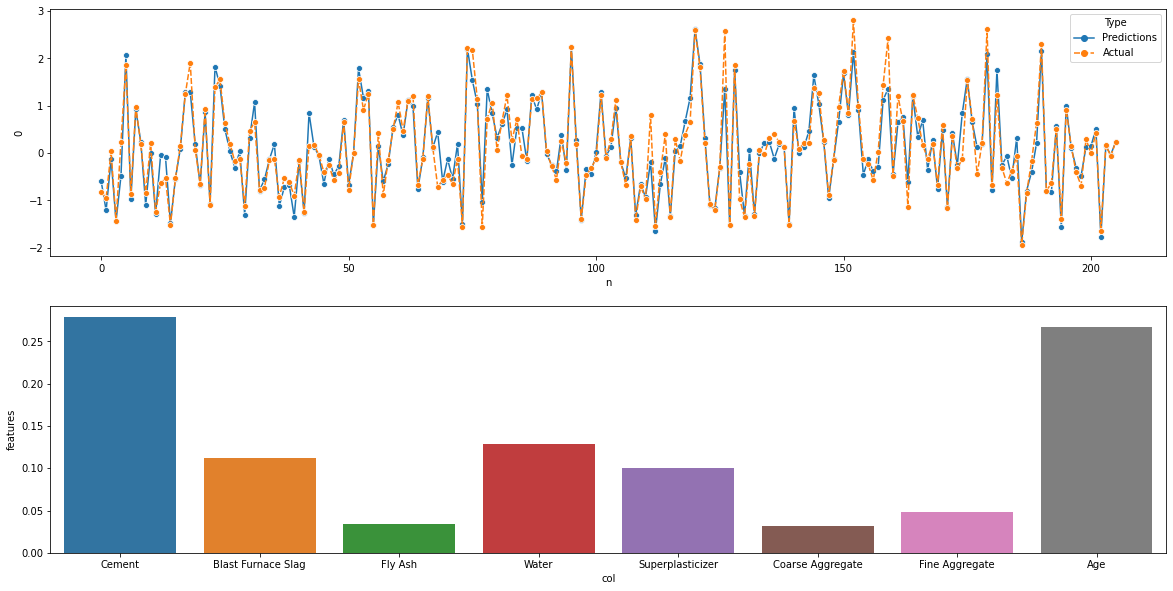

,Multiple Regression,Ridge,Polynomial Regression,Support Vector Regression,KNN,Decision Tree Regression,Random Forest Regression,XGBoost,XGBoost Tuned
Metrics,,,,,,,,,
Root Mean Squared Error (RMSE),0.546891,0.546698,0.405546,0.556643,0.562138,0.403402,0.320282,0.323593,0.295074
Mean Absolute Error (MAE),0.409823,0.409903,0.270600,0.415192,0.392322,0.250370,0.221552,0.228114,0.194962
Mean Squared Error (MSE),0.299089,0.298878,0.164468,0.309851,0.315999,0.162733,0.102580,0.104713,0.087069
R2 score,0.679815,0.680041,0.824881,0.668295,0.661713,0.825789,0.890185,0.887902,0.906790
CV-mean,0.646425,0.647082,-7.329658,0.634801,0.501885,0.514253,0.779055,0.814768,0.800836


In [ ]:
xgc = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1,
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1)
evaluation, cv_scores =  evaluate_model("XGBoost Tuned", train_X, train_y, test_X, test_y, "Features", xgc)
evaluation.set_index("Metrics")

In [ ]:
forest_regression_result = forest_regression.fit(train_X,train_y)

In [ ]:
forest_regression_result.score(test_X,test_y)

0.8458488526715365

In [ ]:
poly_features = PolynomialFeatures().fit_transform(train_X)
poly_regression_result = linear_regression.fit(poly_features,train_y)

In [ ]:
poly_features = PolynomialFeatures().fit_transform(test_X)
poly_regression_result.score(poly_features,test_y)

0.8071441867510338

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# define regression model
def regression_model(predictors):
    # create model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(predictors,)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='softmax'))
    model.add(Dense(1))
    
    # compile model
    optim = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optim, loss='mean_squared_error')
    return model

In [ ]:
model = regression_model(train_X.shape[1])

In [ ]:
# fit the model
model.fit(train_X, train_y, epochs=200, verbose=2)

Epoch 1/200
26/26 - 0s - loss: 0.7196 - 407ms/epoch - 16ms/step
Epoch 2/200
26/26 - 0s - loss: 0.4376 - 60ms/epoch - 2ms/step
Epoch 3/200
26/26 - 0s - loss: 0.3312 - 60ms/epoch - 2ms/step
Epoch 4/200
26/26 - 0s - loss: 0.2514 - 55ms/epoch - 2ms/step
Epoch 5/200
26/26 - 0s - loss: 0.1971 - 56ms/epoch - 2ms/step
Epoch 6/200
26/26 - 0s - loss: 0.1591 - 56ms/epoch - 2ms/step
Epoch 7/200
26/26 - 0s - loss: 0.1270 - 56ms/epoch - 2ms/step
Epoch 8/200
26/26 - 0s - loss: 0.1335 - 57ms/epoch - 2ms/step
Epoch 9/200
26/26 - 0s - loss: 0.1169 - 58ms/epoch - 2ms/step
Epoch 10/200
26/26 - 0s - loss: 0.1088 - 65ms/epoch - 3ms/step
Epoch 11/200
26/26 - 0s - loss: 0.0974 - 55ms/epoch - 2ms/step
Epoch 12/200
26/26 - 0s - loss: 0.0968 - 56ms/epoch - 2ms/step
Epoch 13/200
26/26 - 0s - loss: 0.0972 - 55ms/epoch - 2ms/step
Epoch 14/200
26/26 - 0s - loss: 0.0951 - 54ms/epoch - 2ms/step
Epoch 15/200
26/26 - 0s - loss: 0.0861 - 58ms/epoch - 2ms/step
Epoch 16/200
26/26 - 0s - loss: 0.0989 - 58ms/epoch - 2ms/step

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)

In [ ]:
score = 100*(1-score)
score

88.11069428920746